In [23]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

def yc_patch(A,l1,l2,o1,o2):

    n1,n2=np.shape(A);
    tmp=np.mod(n1-l1,o1)
    if tmp!=0:
        #print(np.shape(A), o1-tmp, n2)
        A=np.concatenate([A,np.zeros((o1-tmp,n2))],axis=0)

    tmp=np.mod(n2-l2,o2);
    if tmp!=0:
        A=np.concatenate([A,np.zeros((A.shape[0],o2-tmp))],axis=-1); 


    N1,N2 = np.shape(A)
    X=[]
    for i1 in range (0,N1-l1+1, o1):
        for i2 in range (0,N2-l2+1,o2):
            tmp=np.reshape(A[i1:i1+l1,i2:i2+l2],(l1*l2,1));
            X.append(tmp);  
    X = np.array(X)
    return X[:,:,0]

def Normalization(x):
    max_x = x.max()
    min_x = x.min()
    norm_out = (x-min_x)/(max_x-min_x)
    return norm_out

def DeNorm(x, norm_x):
    max_x = x.max()
    min_x = x.min()
    denorm = norm_x*(max_x-min_x)+min_x
    return denorm

def min_max_scaling(new, data):
    original_min = np.min(data)
    original_max = np.max(data)
    new_max = np.max(new)
    new_min = np.min(new)
    scaled_data = (data - original_min) / (original_max - original_min) * (new_max - new_min) + new_min
    return scaled_data

def normalize_to_minus_one_one(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = -1 + 2 * ((data - min_val) / (max_val - min_val))
    return normalized_data

def denormalize_minmax(normalized_array, min_value, max_value):
    denormalized_array = normalized_array * (max_value - min_value) + min_value
    return denormalized_array

def denormalize(original_array, normalized_array):
    """
    정규화된 배열을 다시 원래의 범위로 되돌리는 함수
    """
    min_val = original_array.min()
    max_val = original_array.max()
    mean_val = original_array.mean()
    std_val = original_array.std()
    
    denormalized_array = normalized_array * (max_val - min_val) + min_val
    denormalized_array = denormalized_array * std_val + mean_val
    return denormalized_array

def yc_patch_inv(X1,n1,n2,l1,l2,o1,o2):
    
    tmp1=np.mod(n1-l1,o1)
    tmp2=np.mod(n2-l2,o2)
    if (tmp1!=0) and (tmp2!=0):
        A     = np.zeros((n1+o1-tmp1,n2+o2-tmp2))
        mask  = np.zeros((n1+o1-tmp1,n2+o2-tmp2)) 

    if (tmp1!=0) and (tmp2==0): 
        A   = np.zeros((n1+o1-tmp1,n2))
        mask= np.zeros((n1+o1-tmp1,n2))


    if (tmp1==0) and (tmp2!=0):
        A    = np.zeros((n1,n2+o2-tmp2))   
        mask = np.zeros((n1,n2+o2-tmp2))   


    if (tmp1==0) and (tmp2==0):
        A    = np.zeros((n1,n2))
        mask = np.zeros((n1,n2))

    N1,N2= np.shape(A)
    ids=0
    for i1 in range(0,N1-l1+1,o1):
        for i2 in range(0,N2-l2+1,o2):
            #print(i1,i2)
    #       [i1,i2,ids]
            A[i1:i1+l1,i2:i2+l2]=A[i1:i1+l1,i2:i2+l2]+np.reshape(X1[:,ids],(l1,l2))
            mask[i1:i1+l1,i2:i2+l2]=mask[i1:i1+l1,i2:i2+l2]+ np.ones((l1,l2))
            ids=ids+1


    A=A/mask;  
    A=A[0:n1,0:n2]

    return A

In [124]:
testset = np.fromfile('/home/jbgpl/Downloads/SR_denoising/SeismicSuperResolution/data/ExA/Volvestack_384x896.dat', dtype=np.float32).astype(np.float32)
testset = normalize_to_minus_one_one(testset)*4
print(testset.max(), testset.min())
testset.tofile('/home/jbgpl/Downloads/SR_denoising/SeismicSuperResolution/data/ExA/Volvestack_384x896.dat')

4.0 -4.0


In [3]:
imaging = np.fromfile('/home/jbgpl/Downloads/SR_denoising/SeismicSuperResolution/experiment/alpha6/results-field/kumano2_1216x800.dat', dtype=np.float32).astype(np.float32).reshape(1216, 800).T

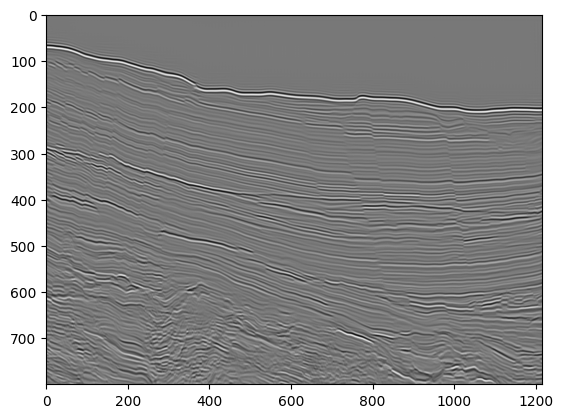

In [4]:
plt.imshow(imaging,aspect='auto',cmap='gray')
plt.show()

Field Data Unpatching

(350, 608)
1.0
(561, 9216)
(561, 1, 96, 96)


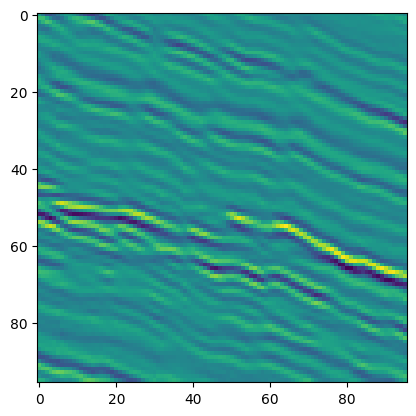

In [24]:
from scipy.ndimage import zoom
# testset = np.load('/home/jbgpl/Downloads/SR_denoising/ESRT/Test_Datasets/field/Volvestack_seis_384_896.npy').astype(np.float32)[:,200:].T
# testset = np.fromfile('/home/jbgpl/Downloads/SR_denoising/ESRT/Test_Datasets/field/lulia_592x400.dat',dtype='float32').reshape(592,-1).T
testset = np.fromfile('/home/jbgpl/Downloads/SR_denoising/ESRT/Test_Datasets/field/kumano2_608x400.dat',dtype='float32').reshape(-1,400)[:,50:].T
# testset = np.fromfile('/home/jbgpl/Downloads/SR_denoising/ESRT/Test_Datasets/field/tp_352x240.dat',dtype='float32').reshape(-1,240).T

# testset = adjust_filter_intensity(testset, 0.5)
testset = normalize_to_minus_one_one(testset)

#testset = zoom(testset, 2, order=5)
print(testset.shape)
#testset = normalize_to_minus_one_one(testset)*10


l1 = 96
l2 = 96
o11 = 16
o22 = 16
print(testset.max())
# print(testset[0].shape)
# testset_norm = Normalization(testset[0])
image = yc_patch(testset,l1,l2,o11,o22)
print(image.shape)
image = image.reshape(-1,1,96,96)
print(image.shape)
plt.imshow(image[100][0])
plt.show()

In [25]:
for i in range(0,len(image)):
    image_patch = image[i].T.astype(np.float32)
    image_patch = normalize_to_minus_one_one(image_patch)*3
    image_patch.tofile('/home/jbgpl/Downloads/SR_denoising/SeismicSuperResolution/data/field_kumano2_patch96/patch'+str(i).zfill(4)+'_96x96.dat')
print(image_patch.dtype)

float32


In [11]:
print(image_patch.max())

3.0


Field Patching

In [26]:
i=0
aa = np.fromfile('/home/jbgpl/Downloads/SR_denoising/SeismicSuperResolution/experiment/ESRT_paper/results-field_kumano2_patch96/patch'+str(i).zfill(4)+'_192x192.dat', dtype='float32').reshape(192,-1,1).T
#aa = normalize_to_minus_one_one(aa)
aa = min_max_scaling(image[i],aa)
for i in range(1,len(image)):
    unet_SR_patched = np.fromfile('/home/jbgpl/Downloads/SR_denoising/SeismicSuperResolution/experiment/ESRT_paper/results-field_kumano2_patch96/patch'+str(i).zfill(4)+'_192x192.dat', dtype='float32').reshape(192,-1,1).T
    #unet_SR_patched = normalize_to_minus_one_one(unet_SR_patched)
    unet_SR_patched = min_max_scaling(image[i],unet_SR_patched)
    aa = np.concatenate([aa,unet_SR_patched],0)

print(aa.shape)
out = aa.reshape(len(image),-1).T
l1 = 192
l2 = 192
o1 = o11*2
o2 = o22*2
    #img = np.concatenate([img,img1],axis=0)



n1,n2 = testset.shape
n1 = n1*2
n2 = n2*2
#print(n1,n2)
unet_output = yc_patch_inv(out,n1,n2,l1,l2,o1,o2)


(561, 192, 192)


Text(0.5, 1.0, 'Min-Max scale')

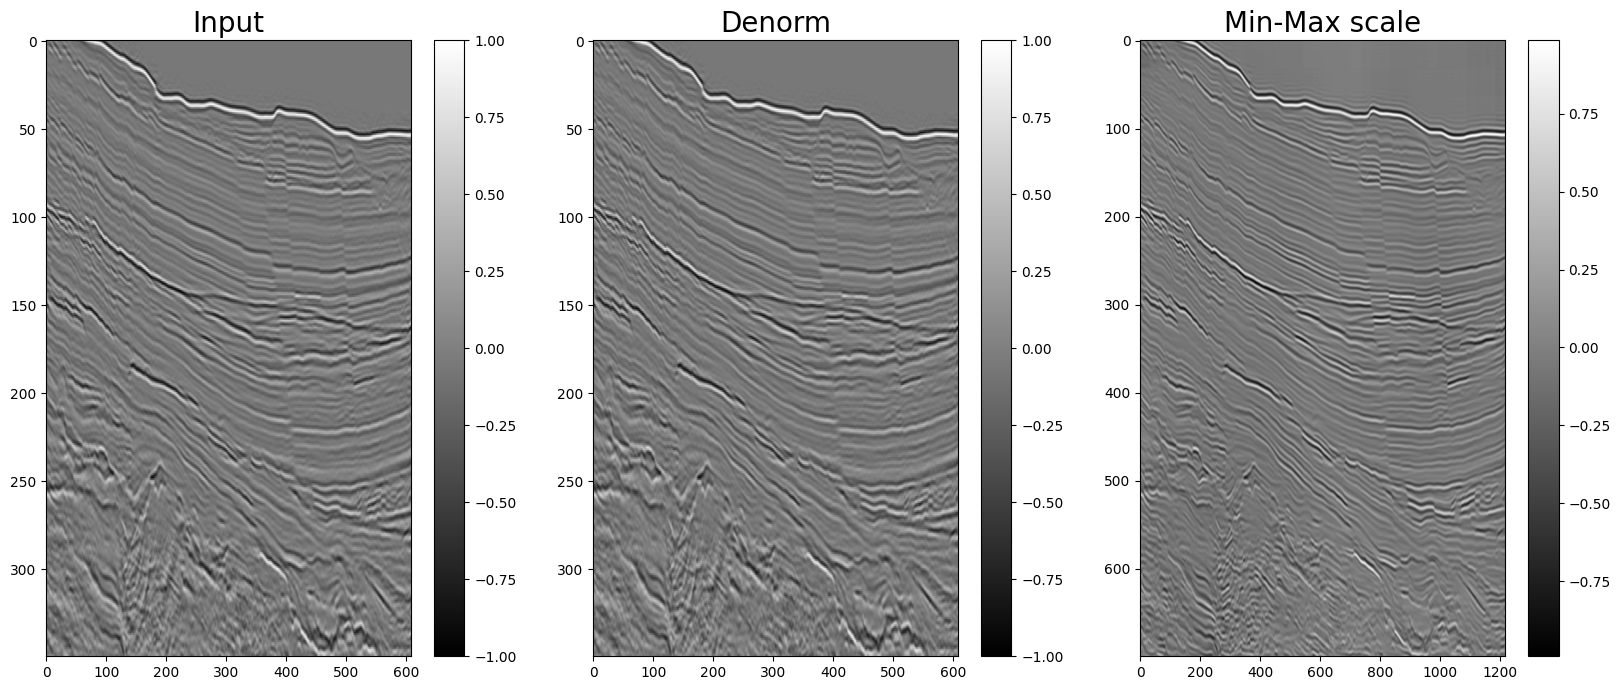

In [27]:
# Plotting the results.
fig = plt.figure(figsize=(20,8))
plt.subplot(1,3,1),plt.imshow(testset,aspect='auto',cmap='gray')
plt.colorbar(label="", orientation="vertical") 
plt.title('Input', fontsize=20)
plt.subplot(1,3,2),plt.imshow(testset,aspect='auto',cmap='gray')
plt.colorbar(label="", orientation="vertical") 
plt.title('Denorm', fontsize=20)
plt.subplot(1,3,3),plt.imshow(unet_output,aspect='auto',cmap='gray')
plt.colorbar(label="", orientation="vertical") 
plt.title('Min-Max scale', fontsize=20)

In [7]:
unet_denorm = unet_output

In [54]:
testset_save = testset.astype('float32').T
testset_save.tofile('/home/jbgpl/Downloads/SR_denoising/ESRT/result/field/lulia_1216_800_scale_epoch800.dat')

In [28]:
print(unet_output.shape)

(700, 1216)


In [29]:
unet_output_save = unet_output.astype('float32').T
unet_output_save.tofile('/home/jbgpl/Downloads/SR_denoising/ESRT/result/field/kumano2_1216_700_Unet_scale_250_patch96.bin')

In [49]:
testset = np.load('/home/jbgpl/Downloads/SR_denoising/ESRT/Test_Datasets/field/Volvestack_seis_384_896.npy').astype(np.float32)
testset = testset.astype('float32')
testset.tofile('/home/jbgpl/Downloads/SR_denoising/ESRT/Test_Datasets/field/Volvestack_seis_384_896.bin')

In [128]:
aa=np.fromfile('/nas/01_research/01_real_data/02_land/01_UtahFORGE/03_Microseismic/FM2Juwon/rr3d.bin',dtype='float32')
print(aa)

[0.78061986 0.55244994 0.14528    0.78061986 0.55244994 0.17576003
 0.78061986 0.55244994 0.20624    0.78061986 0.55244994 0.23671997
 0.78061986 0.55244994 0.2672     0.78061986 0.55244994 0.29768002
 0.78061986 0.55244994 0.32816    0.78061986 0.55244994 0.35864002
 0.78061986 0.55244994 0.38911998 0.78061986 0.55244994 0.41959995
 0.78061986 0.55244994 0.45008004 0.78061986 0.55244994 0.48056   ]


In [129]:
bb=np.fromfile('/nas/01_research/01_real_data/02_land/01_UtahFORGE/03_Microseismic/FM2Juwon/ss1.bin',dtype='float32')
print(bb)

[0.37999994 0.6270001  1.665     ]
